In [19]:
from braket.circuits import Circuit
from braket.aws import AwsDevice
from braket.devices import LocalSimulator
import itertools

In [20]:
def plot_histogram(counts):
    """Plot histogram of measurement results.

    Args:
        counts (dict[str,int]): Mapping from measured bitstrings (e.g. '0101')
            to the number of shots that produced that bitstring.
    """
    import matplotlib.pyplot as plt

    states = list(counts.keys())
    values = list(counts.values())

    plt.bar(states, values)
    plt.xlabel("Bitstring")
    plt.ylabel("Counts")
    plt.show()


# --- Helper functions for "classical fingerprinting" of results ----------------
# 1) Run a circuit many times ("shots"), producing a list of 0/1 measurement outcomes
# 2) Compute, for each qubit, the empirical probability of measuring '1'
# 3) Quantize each probability into a fixed-precision binary representation
# 4) Concatenate those binary chunks into one long bitstring "fingerprint"
# 5) Compare fingerprints from different runs/devices using Hamming distance


def float_to_bits(x, n_bits=5):
    """Quantize a probability x in [0,1) into an n_bits binary string.

    Example:
        n_bits=5 -> bins of size 1/32.
        x=0.125 -> integer=4 -> '00100'

    Notes:
        - We use a half-open interval [0,1) so that x=1.0 is excluded.
          (With finite shots you usually won't get exactly 1.0 anyway.)
    """
    assert 0.0 <= x < 1.0
    integer = int(x * (2 ** n_bits))  # floor into one of 2**n_bits bins
    return format(integer, f"0{n_bits}b")  # zero-padded binary string


def prob1_bitstring(result, precision=5):
    """Convert a Braket Result into a fixed-length bitstring fingerprint.

    For each qubit i:
        p_i = (# of shots where qubit i measured 1) / (total shots)
        bits_i = float_to_bits(p_i, precision)

    Then returns the concatenation:
        bits_0 + bits_1 + ... + bits_{num_qubits-1}

    Args:
        result: Braket task result object. Must have `result.measurements`
            as a list/array of shape (shots, num_qubits).
        precision (int): Number of bits used per qubit probability.

    Returns:
        str: A bitstring of length (num_qubits * precision).
    """
    data = result.measurements  # shape: (shots, num_qubits)

    num_qubit = len(data[0])
    shot_number = len(data)

    # Calculate empirical P(measurement == 1) for each qubit
    prob_list = []
    for i in range(num_qubit):
        ones = 0
        for step in range(shot_number):
            if data[step][i] == 1:
                ones += 1
        prob_list.append(float_to_bits(ones / shot_number, precision))

    # Concatenate per-qubit probability bits into one long fingerprint
    bitstring = ""
    for prob in prob_list:
        bitstring += prob

    return bitstring


def hamming_distance(a, b):
    """Return the Hamming distance between two equal-length bitstrings."""
    return sum(x != y for x, y in zip(a, b))


def average_hamming_distance(bitlist):
    """Compute the average (pairwise) normalized Hamming distance in percent.

    This compares all unique pairs of bitstrings in `bitlist`.
    Inter or Intra Depending on the Input bitlist.

    Interpretation:
      - "Inter" distance: compare fingerprints from different devices for the
        *same* circuit/challenge.
      - "Intra" distance: compare fingerprints from the *same* device at different times.

    Args:
        bitlist (list[str]): list of equal-length bitstrings.

    Returns:
        float: average distance in percent (0 to 100).
    """
    n = len(bitlist[0])  # length of each fingerprint bitstring
    distances = []

    for r1, r2 in itertools.combinations(bitlist, 2):
        distances.append(hamming_distance(r1, r2) / n)

    return 100 * sum(distances) / len(distances)


def run_quantum_task(circuit, device_arn, shot_number, prefix):
    """Run a Braket circuit on an AWS device and return the Result.

    This submits a quantum task to the selected device (simulator or QPU),
    storing results in an S3 bucket.

    Args:
        circuit (Circuit): Braket circuit to execute.
        device_arn (str): ARN of the target Braket device.
        shot_number (int): Number of shots.
        prefix (str): Subfolder used within the S3 prefix (helps organize results).

    Returns:
        Result: Braket result object (task.result()).
    """
    device = AwsDevice(device_arn)

    # IMPORTANT:
    # - The S3 bucket must exist and you must have permission to write to it.
    # - Braket requires buckets to start with 'amazon-braket-' unless you configured otherwise.
    s3_bucket = "amazon-braket-quen-result-us-west-1"
    s3_prefix = "braket-test/" + prefix

    task = device.run(
        circuit,
        shots=shot_number,
        s3_destination_folder=(s3_bucket, s3_prefix),
    )

    # task.id is useful for tracking the job in the Braket console
    print(task.id)

    # Blocking call: waits until the task is complete and downloads the result
    result = task.result()
    return result


In [21]:
# Experiment parameters
num_q = 10          # number of qubits in each circuit
shot_number = 100   # number of circuit repetitions (shots) per run


In [22]:
# Build two circuits:
# 1) circuit_had: apply H on every qubit (creates an equal superposition)
# 2) circuit_cnot: apply H on every qubit, then entangle the first half with the second half via CNOTs

circuit_had = Circuit()
circuit_cnot = Circuit()

# Put every qubit into |+> = (|0> + |1>)/sqrt(2)
for i in range(num_q):
    circuit_had.h(i)
    circuit_cnot.h(i)

# Add entanglement: CNOT from qubit i to qubit i + num_q/2
# This couples the two halves of the register.
for i in range(int(num_q / 2)):
    circuit_cnot.cnot(i, i + int(num_q / 2))

# Measure all qubits at the end of each circuit
for i in range(num_q):
    circuit_had.measure(i)
    circuit_cnot.measure(i)


In [23]:
print(circuit_had) 
print(circuit_cnot)

T  : │  0  │  1  │
      ┌───┐ ┌───┐ 
q0 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q1 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q2 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q3 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q4 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q5 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q6 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q7 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q8 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q9 : ─┤ H ├─┤ M ├─
      └───┘ └───┘ 
T  : │  0  │  1  │
T  : │  0  │              1              │  2  │
      ┌───┐                               ┌───┐ 
q0 : ─┤ H ├───●───────────────────────────┤ M ├─
      └───┘   │                           └───┘ 
      ┌───┐   │                           ┌───┐ 
q1 : ─┤ H ├───┼─────●─────────────────────┤ M ├─
      └───┘   │     │                     └───┘ 
      ┌───┐   │     │                     ┌───┐ 


## Run Experiment with Local Simulator

Counter({'0100001100': 2, '1010001011': 2, '0000111110': 2, '0011010101': 2, '1110011110': 2, '0011000101': 1, '0100100010': 1, '0011001111': 1, '0101011110': 1, '1110000010': 1, '1111000101': 1, '0100010001': 1, '0011111110': 1, '0111110110': 1, '0000110100': 1, '1100110010': 1, '1011110101': 1, '0111010100': 1, '0001110011': 1, '0100001000': 1, '1011100000': 1, '1111011011': 1, '1011001101': 1, '1000101001': 1, '1011011000': 1, '0111001111': 1, '1010101010': 1, '0100011101': 1, '0011111101': 1, '1100111010': 1, '1100100001': 1, '0111100110': 1, '1100000010': 1, '1000101010': 1, '0110111110': 1, '0000100011': 1, '0101010101': 1, '0010101011': 1, '1001010010': 1, '0000010000': 1, '1001000000': 1, '1100101110': 1, '1010101000': 1, '0011111001': 1, '0001111101': 1, '1000000000': 1, '1111010010': 1, '1010101001': 1, '1011110000': 1, '1100001001': 1, '1100001100': 1, '1010110001': 1, '0010010110': 1, '1101001001': 1, '1001111111': 1, '1011010111': 1, '1100101100': 1, '0110010000': 1, '1010

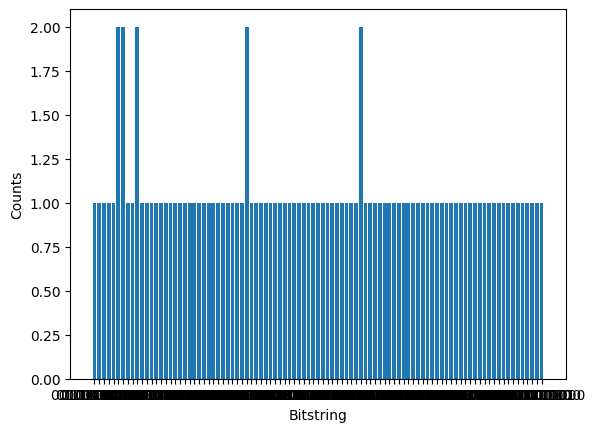

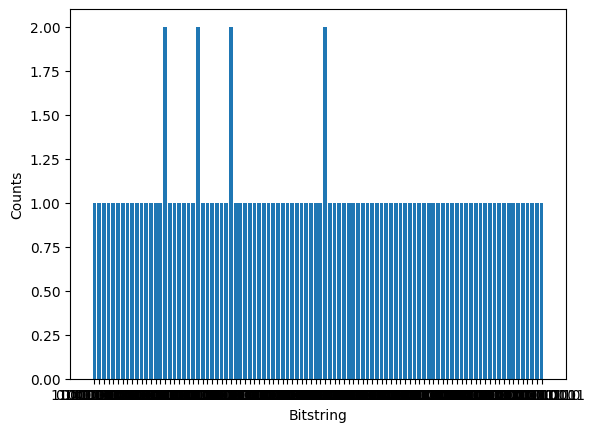

In [17]:
device = LocalSimulator()

result_had = device.run(circuit_had, shots=shot_number).result()
result_cnot = device.run(circuit_cnot, shots=shot_number).result()

# Raw measurement counts (bitstring -> number of shots)
print(result_had.measurement_counts)
print(result_cnot.measurement_counts)

# Visualize the distributions
plot_histogram(result_had.measurement_counts)
plot_histogram(result_cnot.measurement_counts)


Classical post processing of data 
must analyse hamming weight 

First, must calculate for each qubit the probablity of 1. So among the shots, what is the probablity of this qubit ot have 1 must be first coded. and encode that probablity into 5 bits information. then in total, we will have a 5 times 10, 50 bit bitstring which would be the subject of analysing intra and inter hamming distance


In [18]:
# Compute and print the fixed-length fingerprint bitstring for the Hadamard-only circuit.
# Each qubit contributes `precision` bits (default 5) representing P(measure=1) for that qubit.
print(prob1_bitstring(result_had))


10000011111001001110011111000010001011110110101111


## Run with AWS Devices

In [10]:
numberofDevice = 4

devices = AwsDevice.get_devices()

online_device_arn_list = []

for d in devices:
    if d.status == "ONLINE" and "/qpu/" in d.arn and 'braket.ir.openqasm.program' in d.properties.action.keys() :
        online_device_arn_list.append(d)


In [11]:
for device in online_device_arn_list:
    print(device.name)
    print(device.queue_depth())

Ankaa-3
QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '5', <QueueType.PRIORITY: 'Priority'>: '0'}, jobs='0')
Emerald
QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '0', <QueueType.PRIORITY: 'Priority'>: '0'}, jobs='0')
Forte 1
QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '0', <QueueType.PRIORITY: 'Priority'>: '1'}, jobs='2')
Garnet
QueueDepthInfo(quantum_tasks={<QueueType.NORMAL: 'Normal'>: '30', <QueueType.PRIORITY: 'Priority'>: '0'}, jobs='0')


Have chosen devices that are ONLINE, Quanutm Processing Unit, and using qasm format. Can also check the queue depth for each qpu selected.

### CAUTION! WILL BE RUNNIG QPU WITH AWS CREDIT!!

In [ ]:
device = devices[0] #Choose which AWS Device you want to run with

result_had = device.run(circuit_had, shots=shot_number).result()
result_cnot = device.run(circuit_cnot, shots=shot_number).result()

# Raw measurement counts (bitstring -> number of shots)
print(result_had.measurement_counts)
print(result_cnot.measurement_counts)

# Visualize the distributions
plot_histogram(result_had.measurement_counts)
plot_histogram(result_cnot.measurement_counts)

#Create FingerPrint for QPU
print(prob1_bitstring(result_had))

Next Step:
1. Have to fix qubits in the qpu and compare over time
2. Compare with different AWS devices and see inter hamming distance is indeed 50 percent